# Fraud Detection - Model Training & Evaluation

This notebook focuses on training and evaluating machine learning models for the IEEE-CIS Fraud Detection task.

**Data Preparation**: All preprocessing, feature engineering, and selection has been completed in `EDA.ipynb`.

**Models to Compare**:
1. Logistic Regression (baseline)
2. Random Forest
3. XGBoost
4. LightGBM
5. CatBoost

**Evaluation Strategy**: 
- Stratified 5-Fold Cross-Validation (due to class imbalance)
- Metrics: ROC-AUC, Precision, Recall, F1-Score
- Final evaluation on held-out test set

In [1]:
# =============================================================================
# Import Libraries
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Boosting models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier  # Uncomment if installed

# Custom functions
import sys
ROOT = Path.cwd().parent
sys.path.append(str(ROOT / "functions"))

from model_functions import (
    plot_roc_curve, compare_roc_curves, plot_precision_recall_curve,
    plot_confusion_matrix, find_optimal_threshold, evaluate_with_cv,
    full_evaluation_report, compare_models, plot_feature_importance
)

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Preprocessed Data

In [2]:
# =============================================================================
# Load Preprocessed Data from EDA.ipynb
# =============================================================================
import pickle

DATA = ROOT / "data"

# Load DataFrames
train_df = pd.read_parquet(DATA / "train_preprocessed.parquet")
test_df = pd.read_parquet(DATA / "test_preprocessed.parquet")

# Load feature lists
with open(DATA / "feature_lists.pkl", 'rb') as f:
    feature_lists = pickle.load(f)

filtered_features = feature_lists['filtered_features']
categorical_features = feature_lists['categorical_features']
strong_features = feature_lists['strong_features']
moderate_features = feature_lists['moderate_features']

print(f"✅ Data loaded successfully!")
print(f"   Train shape: {train_df.shape}")
print(f"   Test shape: {test_df.shape}")
print(f"   Filtered features: {len(filtered_features)}")

✅ Data loaded successfully!
   Train shape: (472432, 264)
   Test shape: (118108, 264)
   Filtered features: 248


In [3]:
# =============================================================================
# Prepare Features and Target
# =============================================================================

# Prepare train/test sets
X_train = train_df[filtered_features].copy()
y_train = train_df['isFraud'].copy()

X_test = test_df[filtered_features].copy()
y_test = test_df['isFraud'].copy()

# =============================================================================
# Handle Missing Values
# =============================================================================
# Quick fix: Fill NaN with -999 (flag value)
# Tree-based models can learn to split on this value
# For production, consider more sophisticated imputation

missing_before = X_train.isnull().sum().sum()
print(f"Missing values in X_train: {missing_before}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")

# Fill with flag value
MISSING_FLAG = -999
X_train = X_train.fillna(MISSING_FLAG)
X_test = X_test.fillna(MISSING_FLAG)

print(f"\n✅ Filled missing values with {MISSING_FLAG}")
print(f"   Missing after: {X_train.isnull().sum().sum()}")

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nTraining fraud rate: {y_train.mean()*100:.2f}%")
print(f"Test fraud rate: {y_test.mean()*100:.2f}%")

Missing values in X_train: 19392920
Missing values in X_test: 5173875

✅ Filled missing values with -999
   Missing after: 0

X_train shape: (472432, 248)
X_test shape: (118108, 248)

Training fraud rate: 3.51%
Test fraud rate: 3.44%


## 1. Baseline Model: Logistic Regression

A simple baseline to establish minimum performance. Logistic Regression with class weights to handle imbalance.

KeyboardInterrupt: 

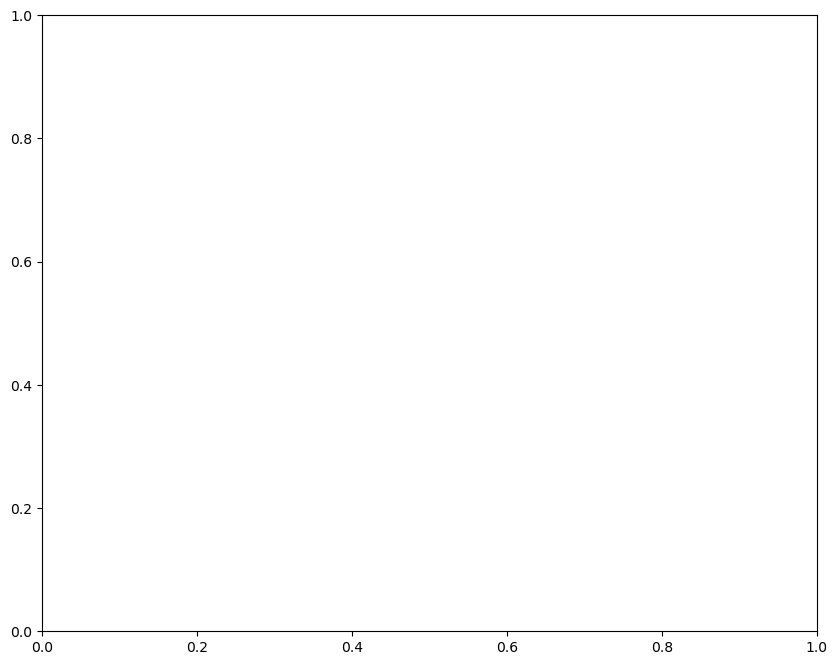

In [5]:
# Logistic Regression requires scaling for numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression with class weight to handle imbalance
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

# Cross-validation evaluation
lr_results = evaluate_with_cv(
    lr_model, 
    pd.DataFrame(X_train_scaled, columns=filtered_features), 
    y_train,
    cv=5,
    plot=True,
    model_name="Logistic Regression"
)

## 2. Random Forest

Tree-based ensemble that handles imbalanced data well with class_weight parameter.

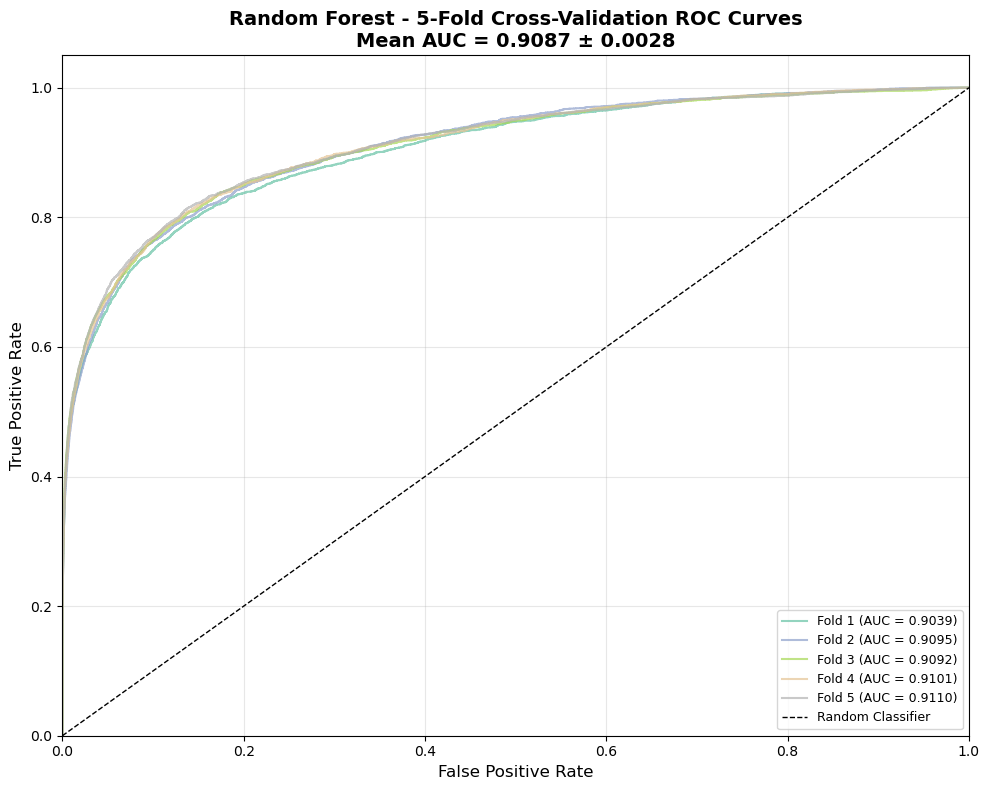


Random Forest - 5-Fold Cross-Validation Results
AUC:       0.9087 ± 0.0028
Precision: 0.3203 ± 0.0114
Recall:    0.6815 ± 0.0154
F1-Score:  0.4356 ± 0.0091
Accuracy:  0.9379 ± 0.0031

Out-of-Fold AUC: 0.9087


In [9]:
# Random Forest with balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Cross-validation evaluation
rf_results = evaluate_with_cv(
    rf_model,
    X_train,
    y_train,
    cv=5,
    plot=True,
    model_name="Random Forest"
)

## 3. XGBoost

Gradient boosting with scale_pos_weight for handling class imbalance.

Scale pos weight: 27.46


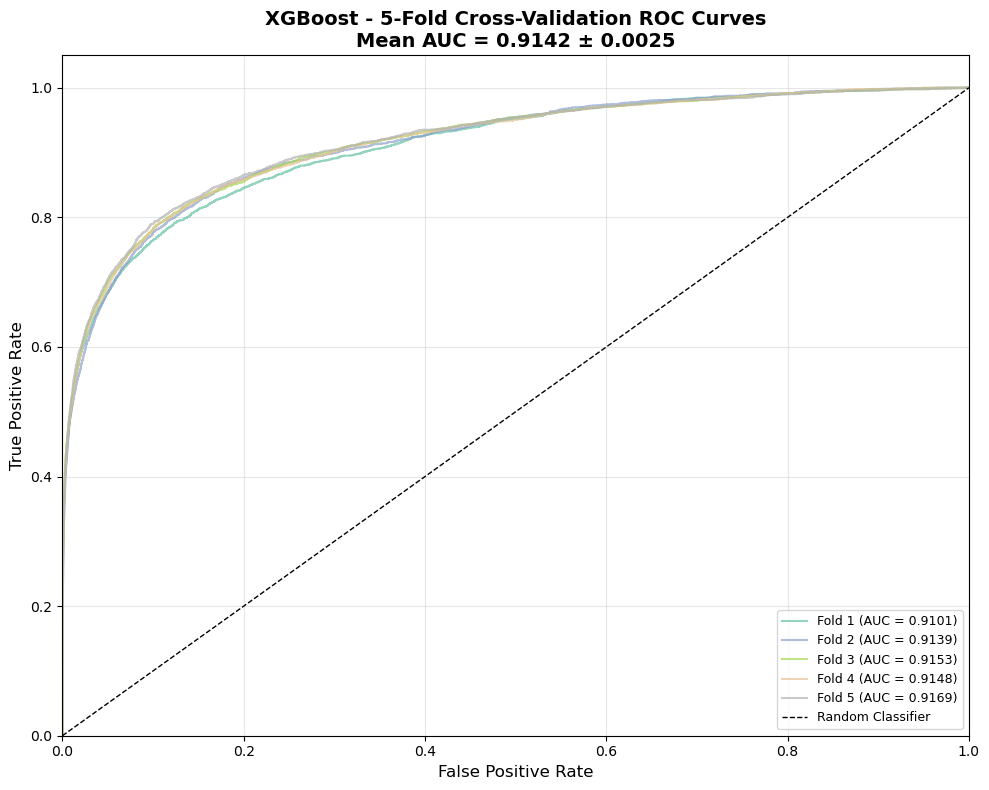


XGBoost - 5-Fold Cross-Validation Results
AUC:       0.9142 ± 0.0025
Precision: 0.2181 ± 0.0027
Recall:    0.7820 ± 0.0113
F1-Score:  0.3411 ± 0.0034
Accuracy:  0.8938 ± 0.0020

Out-of-Fold AUC: 0.9141


In [11]:
# Calculate scale_pos_weight for imbalanced dataset
# Ratio of negative to positive samples
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Cross-validation evaluation
xgb_results = evaluate_with_cv(
    xgb_model,
    X_train,
    y_train,
    cv=5,
    plot=True,
    model_name="XGBoost"
)

## 4. LightGBM

Fast gradient boosting optimized for large datasets. Uses `is_unbalance` or `scale_pos_weight`. 9132

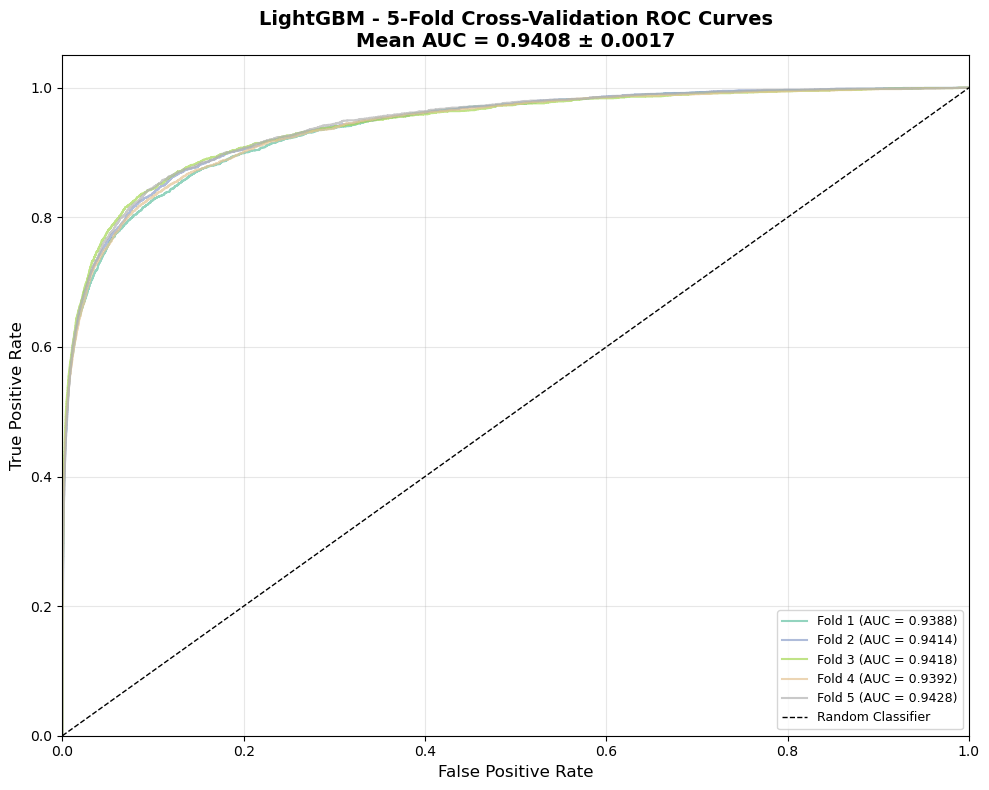


LightGBM - 5-Fold Cross-Validation Results
AUC:       0.9408 ± 0.0017
Precision: 0.2411 ± 0.0099
Recall:    0.8337 ± 0.0102
F1-Score:  0.3739 ± 0.0117
Accuracy:  0.9018 ± 0.0053

Out-of-Fold AUC: 0.9407


In [4]:
# LightGBM model
lgb_model = LGBMClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    is_unbalance=True,  # Alternative: scale_pos_weight=scale_pos_weight
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Cross-validation evaluation
lgb_results = evaluate_with_cv(
    lgb_model,
    X_train,
    y_train,
    cv=5,
    plot=True,
    model_name="LightGBM"
)

## 5. CatBoost (Optional)

Native handling of categorical features. Uncomment if CatBoost is installed.

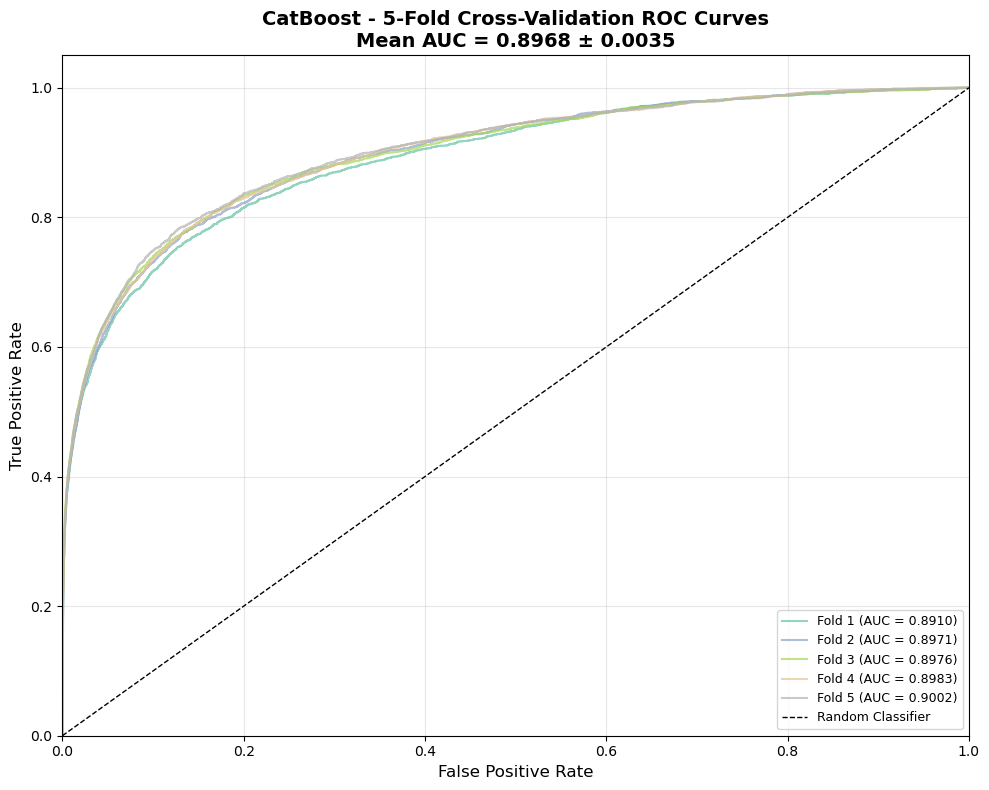


CatBoost - 5-Fold Cross-Validation Results
AUC:       0.8968 ± 0.0035
Precision: 0.1740 ± 0.0029
Recall:    0.7757 ± 0.0096
F1-Score:  0.2843 ± 0.0042
Accuracy:  0.8627 ± 0.0025

Out-of-Fold AUC: 0.8968


In [5]:
# Uncomment if CatBoost is installed
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    auto_class_weights='Balanced',
    eval_metric='AUC',
    random_seed=42,
    verbose=0
)

# Cross-validation evaluation
cat_results = evaluate_with_cv(
    cat_model,
    X_train,
    y_train,
    cv=5,
    plot=True,
    model_name="CatBoost"
)

## Model Comparison

Compare all models on the held-out test set using various metrics.

In [21]:
# =============================================================================
# Train Final Models on Full Training Data
# =============================================================================

# Train all models on full training set
print("Training final models on full training data...")

# Logistic Regression (needs scaled data)
lr_model.fit(X_train_scaled, y_train)
lr_probs = lr_model.predict_proba(X_test_scaled)[:, 1]

# Random Forest
rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# XGBoost
xgb_model.fit(X_train, y_train)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# LightGBM
lgb_model.fit(X_train, y_train)
lgb_probs = lgb_model.predict_proba(X_test)[:, 1]

# CatBoost
cat_model.fit(X_train , y_train)
cat_probs = cat_model.predict_proba(X_test)[:, 1]

print("All models trained!")

Training final models on full training data...
All models trained!


In [8]:
# Compare ROC curves
predictions = {
    'Logistic Regression': lr_probs,
    'Random Forest': rf_probs,
    'XGBoost': xgb_probs,
    'LightGBM': lgb_probs
}

# Add CatBoost if trained
predictions['CatBoost'] = cat_probs

auc_comparison = compare_roc_curves(y_test, predictions)

NameError: name 'lr_probs' is not defined

In [7]:
# Full comparison table with all metrics
comparison_df = compare_models(y_test, predictions, threshold=0.5)
display(comparison_df)

NameError: name 'predictions' is not defined

## Best Model - Full Evaluation

Select the best performing model and run a comprehensive evaluation.

In [6]:
# Select best model based on ROC-AUC (typically LightGBM or XGBoost for fraud detection)
best_model_name = comparison_df.iloc[0]['Model']
best_probs = predictions[best_model_name]

print(f"Best performing model: {best_model_name}")
print(f"Running full evaluation report...\n")

# Full evaluation report with optimal threshold finding
report = full_evaluation_report(y_test, best_probs, model_name=best_model_name)

NameError: name 'comparison_df' is not defined

## Feature Importance Analysis

Understand which features contribute most to the model's predictions.

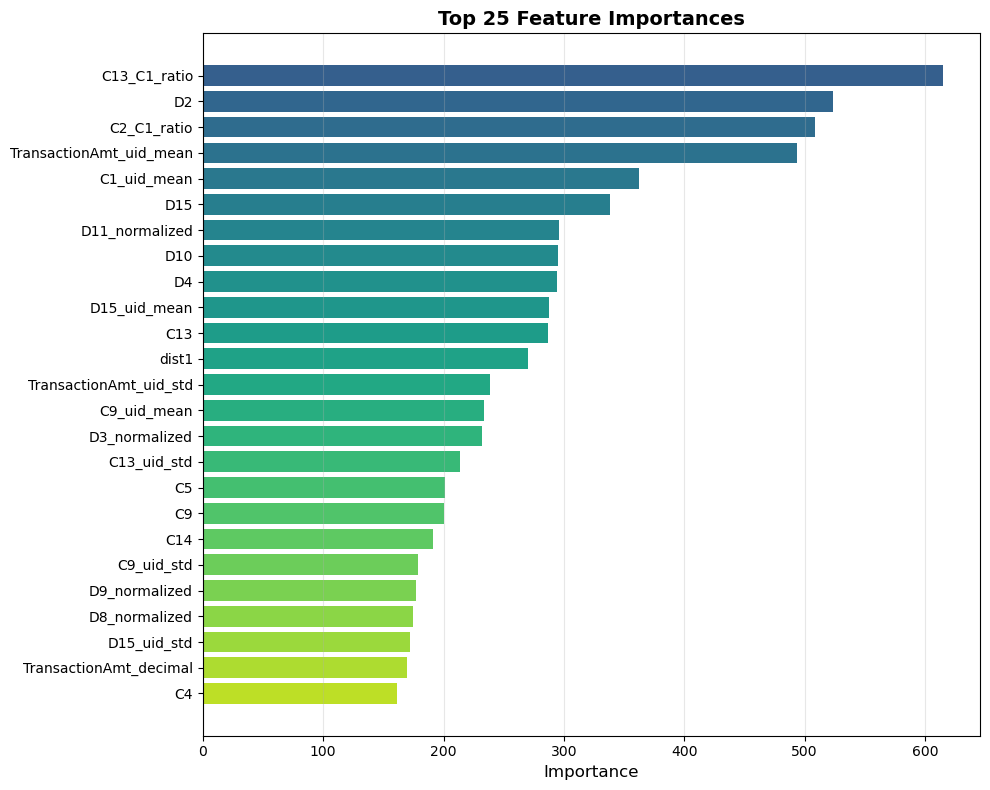


Top 10 Most Important Features:


,Feature,Importance
0,C13_C1_ratio,615
1,D2,524
2,C2_C1_ratio,509
3,TransactionAmt_uid_mean,494
4,C1_uid_mean,362
5,D15,338
6,D11_normalized,296
7,D10,295
8,D4,294
9,D15_uid_mean,288


In [26]:
# Feature importance from LightGBM (or best tree-based model)
importance_df = plot_feature_importance(lgb_model, filtered_features, top_n=25)

# Display top 10 features
print("\nTop 10 Most Important Features:")
display(importance_df.head(10))

## Summary & Next Steps

### Results Summary
- Models compared: Logistic Regression (baseline), Random Forest, XGBoost, LightGBM
- Best model selected based on ROC-AUC on held-out test set
- Optimal threshold determined using F1-score optimization

### Potential Next Steps
1. **Hyperparameter Tuning**: Use Optuna or GridSearchCV for fine-tuning
2. **Ensemble Methods**: Stack or blend top-performing models
3. **Threshold Optimization**: Consider business costs for FP vs FN
4. **SHAP Analysis**: Deeper interpretability with SHAP values
5. **Model Deployment**: Save best model for production use

In [18]:
# =============================================================================
# Save Best Model (Optional)
# =============================================================================
import joblib

# Save the best model
# model_path = ROOT / "models" / f"best_model_{best_model_name.lower().replace(' ', '_')}.pkl"
# joblib.dump(lgb_model, model_path)  # or whichever is best
# print(f"Model saved to: {model_path}")